In [2]:
import pandas as pd
import tensorflow 
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
import re
import sklearn
from sklearn.model_selection import train_test_split
import tqdm
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.pipeline import make_pipeline

2024-04-26 19:52:22.721171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 19:52:22.721229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 19:52:22.722768: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
columns  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "latin-1"
dataset = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=columns).sample(frac=1)

dataset = dataset[['sentiment','text']]

dataset['sentiment'] = dataset['sentiment'].replace(4,1)



In [40]:
dataset[dataset['sentiment']==0]

,sentiment,text
559705,0,scheiÃe ich verpass die kÃ¶rmes in willofs h...
502347,0,So sad not having a laptop
381387,0,"wats going on with this s**t weather, it was 2..."
248012,0,beautiful days are really bad for business
386418,0,Does not feel like a 3 hour serving coffee shi...
...,...,...
592727,0,I need a memory card
683196,0,"was super excited about the beach bonfire, but..."
400181,0,@americannamor Oh noes
325306,0,@Kat_LB i can't belive Maddy is dead


In [5]:
dataset['sentiment'].unique()

array([1, 0])

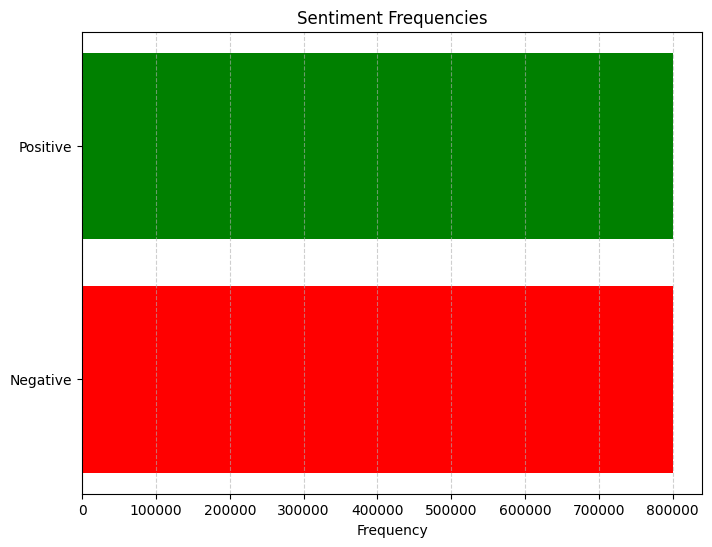

In [6]:
plt.rcParams['font.family'] = 'DejaVu Sans'
sentiment_counts = dataset['sentiment'].value_counts()
sentiment_labels = {'Negative': 0, 'Positive': 1}
plt.figure(figsize=(8, 6))
plt.barh(list(sentiment_labels.keys()), list(sentiment_counts.values), color=['red', 'green', 'blue'])
plt.xlabel("Frequency")
plt.yticks(list(sentiment_labels.values()), list(sentiment_labels.keys()))
plt.title("Sentiment Frequencies")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

In [7]:
dataset.isna().sum()

sentiment    0
text         0
dtype: int64

In [8]:
x,y=dataset['text'],dataset['sentiment']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=True)

In [9]:
len(x_train),len(x_test)

(1280000, 320000)

In [10]:
def process_text(document,stopwords=STOPWORDS):
    nlp = spacy.load("en_core_web_sm")
    document = re.sub(r'\s+', ' ', document, flags=re.I) 
    document = re.sub(r'\W', ' ', str(document))
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document) 
    document = document.lower() 
    doc_spacy=nlp(document)
    lemma_txt = ["".join(token.lemma_) for token in tqdm.tqdm(doc_spacy)]
    lemma_no_stop_txt = [word for word in lemma_txt if word not in stopwords]
    lemma_no_stop_txt = [word for word in lemma_no_stop_txt if len(word) > 3]
    clean_txt = ' '.join(lemma_no_stop_txt)
    return clean_txt

x_train_preprocessed= x_train

In [11]:
x_train_preprocessed

400865     @mynameiscal I'm doing nothing  I'm DEAD BORED...
108422     FINALLY IN AMERICA my sister is like laying ne...
1293286    Had a gr8 wkout this morning.  Now at wilmingt...
1452150    @mock_heroic Way to inherit an iPhone! Better ...
1077312    i'm going now !! had such a good week so far  ...
                                 ...                        
88186        @hanaames hamstrings gone  and i'm not a bubby!
1031974                 @djwj awwwwww realllyy??? *blushin* 
563062     A Dejavu Again: this world cup is same as one ...
1454079                @americanidolluv  so where do u live?
807807                is going to Bob Dylan concert tonight 
Name: text, Length: 1280000, dtype: object

In [12]:
x_train_preprocessed.to_csv('/kaggle/working/x_train_preprocessed.csv')


In [54]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(x_train_preprocessed)  # Ensure consistent preprocessing
X_train_sequences = tokenizer.texts_to_sequences(x_train_preprocessed)
X_test_sequences = tokenizer.texts_to_sequences(x_test)
max_sequence_length = max([len(seq) for seq in X_train_sequences])
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)
pd.DataFrame({'words':tokenizer.sequences_to_texts(list(X_train_sequences)),'sequances':X_train_sequences})

,words,sequances
0,mynameiscal i'm doing nothing i'm dead bored t...,"[196564, 20, 186, 262, 20, 639, 267, 275, 15, ..."
1,finally in america my sister is like laying ne...,"[238, 11, 1646, 6, 631, 9, 35, 1236, 163, 3, 1..."
2,had a gr8 wkout this morning now at wilmington...,"[67, 5, 2272, 70805, 27, 98, 28, 24, 18724, 52..."
3,mock heroic way to inherit an iphone better ma...,"[7760, 41741, 132, 3, 51880, 96, 369, 138, 129..."
4,i'm going now had such a good week so far bye ...,"[20, 48, 28, 67, 316, 5, 29, 146, 16, 372, 604..."
...,...,...
1279995,hanaames hamstrings gone and i'm not a bubby,"[26602, 54115, 340, 7, 20, 25, 5, 20301]"
1279996,djwj awwwwww realllyy blushin,"[594960, 6140, 42730, 117288]"
1279997,a dejavu again this world cup is same as one i...,"[5, 37337, 109, 27, 309, 996, 9, 264, 86, 55, ..."
1279998,americanidolluv so where do u live,"[594961, 16, 214, 42, 54, 271]"


In [14]:
y_train

400865     0
108422     0
1293286    1
1452150    1
1077312    1
          ..
88186      0
1031974    1
563062     0
1454079    1
807807     1
Name: sentiment, Length: 1280000, dtype: int64

In [15]:
len(tokenizer.word_index)

594961

In [16]:
model = Sequential([
Embedding(len(tokenizer.word_index)+1, 64),
Conv1D(64, 3, activation='relu'),
MaxPooling1D(2,2),
Conv1D(32,3, activation='relu'),
MaxPooling1D(2,2),
Flatten(),
Dense(8, activation='relu'),
Dense(1, activation='sigmoid'),]
)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
Early_Stopping=tensorflow.keras.callbacks.EarlyStopping(patience=5,verbose=1)
history=model.fit(X_train_padded,y_train, epochs=10,batch_size=128,callbacks=[Early_Stopping])

Epoch 1/10
   21/10000 ━━━━━━━━━━━━━━━━━━━━ 1:24 8ms/step - accuracy: 0.5106 - loss: 0.6932

I0000 00:00:1714161266.891024     394 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 88s 8ms/step - accuracy: 0.7873 - loss: 0.4449
Epoch 2/10
    7/10000 ━━━━━━━━━━━━━━━━━━━━ 1:24 8ms/step - accuracy: 0.8746 - loss: 0.2933   

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.8816 - loss: 0.2829
Epoch 3/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9254 - loss: 0.1859
Epoch 4/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9475 - loss: 0.1331
Epoch 5/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9601 - loss: 0.1023
Epoch 6/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9677 - loss: 0.0833
Epoch 7/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.9726 - loss: 0.0707
Epoch 8/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.9765 - loss: 0.0609
Epoch 9/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9791 - loss: 0.0543
Epoch 10/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.9812 - loss: 0.0489


In [22]:
test_history=model.evaluate(X_test_padded,y_test)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7811 - loss: 1.0272


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (128, 118, 64)         │    38,077,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (128, 116, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (128, 58, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (128, 56, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (128, 28, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (128, 896)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (128, 8)               │         7,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (128, 1)               │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,309,845 (436.06 MB)

 Trainable params: 38,103,281 (145.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,206,564 (290.70 MB)

In [24]:
X_train_padded

array([[    0,     0,     0, ...,    56,     3,    42],
       [    0,     0,     0, ...,   297,    15,   111],
       [    0,     0,     0, ...,   524,    29,    98],
       ...,
       [    0,     0,     0, ...,  1372,     4, 36909],
       [    0,     0,     0, ...,    42,    54,   271],
       [    0,     0,     0, ...,  5170,   584,   124]], dtype=int32)

In [85]:
def predict_sentiment(input_text, model, tokenizer,max_sequence_length=max_sequence_length):
    classes = ['Negative', 'Positive']
    x_test_sequences = tokenizer.texts_to_sequences(input_text)
    X_test_padded = pad_sequences(x_test_sequences, maxlen=max_sequence_length, truncating='pre')
    probabilities = model.predict(X_test_padded)
    predictions = classes[int(np.round([i for i in probabilities]))]
    return predictions

input_text = ['Does feel good']
predictions = predict_sentiment(input_text, model, tokenizer)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Positive


/tmp/ipykernel_352/1431411651.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions = classes[int(np.round([i for i in probabilities]))]


In [86]:
 predict_sentiment(['ifeel that i didnt drink any coffe from 10 months'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/tmp/ipykernel_352/1431411651.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions = classes[int(np.round([i for i in probabilities]))]


'Negative'

In [87]:
 predict_sentiment(['ifeel that drink any coffe ,iam happy and have big contractions '], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/tmp/ipykernel_352/1431411651.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions = classes[int(np.round([i for i in probabilities]))]


'Positive'

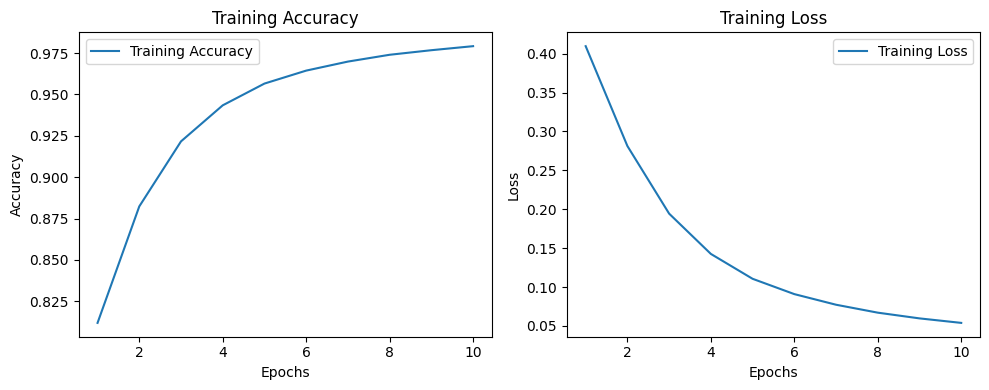

In [89]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    train_accuracy = history.history['accuracy']
    train_loss = history.history['loss']

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)